### Example notebook demonstrating how to use the phenomic-ai package to infer embeddings wrt. a single cell RNA .h5ad file

In [79]:
import os
import pandas as pd
import seaborn as sns
import scanpy as sc
import numpy as np
import matplotlib.pyplot as plt

In [9]:
! pip install -U phenomic-ai  # install/update phenomic-ai dependency/package  # https://pypi.org/project/phenomic-ai/

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.9/54.9 kB 1.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.9/24.9 MB 9.6 MB/s eta 0:00:00:00:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 397.7/397.7 kB 7.5 MB/s eta 0:00:0000:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 6.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.4/77.4 kB 2.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.0/13.0 MB 9.4 MB/s eta 0:00:00:00:010:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 7.7 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.5/12.5 MB 8.5 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.4/114.4 kB 2.4 MB/s eta 0:00:0000:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.8/53.8 kB 2.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 31.1/31.1 MB 5.4 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.6/20.6 MB 

In [10]:
# import from pai (phenomic-ai dependency/package alias)
from pai.utils.option_choices import tissue_organ_option_choices
from pai.embed import PaiEmbeddings

In [6]:
tmp_dir = "./tmp"  # temporary directory is the root output directory where the downloaded zip files (zips/) and unzipped directories (results/) will be output
if not os.path.exists(tmp_dir):
    os.makedirs(tmp_dir)

In [7]:
print(tissue_organ_option_choices)  # tissue/organ option choices

['adipose', 'adrenal gland', 'bile duct', 'bladder', 'blood', 'brain', 'breast', 'colorectal', 'eye', 'head and neck', 'heart', 'intestine', 'kidney', 'liver', 'lung', 'lymph-node', 'marrow', 'muscle', 'ovaries', 'pancreas', 'placenta', 'pleura', 'prostate', 'salivary gland', 'skin', 'spleen', 'stomach', 'testis', 'thymus', 'thyroid gland', 'uterus', 'vasculature']


In [8]:
pai_embeddings = PaiEmbeddings(tmp_dir=tmp_dir)  # init w/ temporary directory

In [16]:
# wget example scRNA dataset from cellxgene

!wget -P {tmp_dir} https://datasets.cellxgene.cziscience.com/0fd9c007-8ba2-4d87-8568-c938d2631fba.h5ad 

--2024-09-11 16:18:34--  https://datasets.cellxgene.cziscience.com/0fd9c007-8ba2-4d87-8568-c938d2631fba.h5ad
Resolving datasets.cellxgene.cziscience.com (datasets.cellxgene.cziscience.com)... 18.173.219.93, 18.173.219.87, 18.173.219.18, ...
Connecting to datasets.cellxgene.cziscience.com (datasets.cellxgene.cziscience.com)|18.173.219.93|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 591123472 (564M) [binary/octet-stream]
Saving to: ‘./tmp/0fd9c007-8ba2-4d87-8568-c938d2631fba.h5ad’

0fd9c007-8ba2-4d87- 100%[===================>] 563.74M  15.3MB/s    in 35s     

2024-09-11 16:19:10 (15.9 MB/s) - ‘./tmp/0fd9c007-8ba2-4d87-8568-c938d2631fba.h5ad’ saved [591123472/591123472]



In [19]:
# Run inference  

h5ad_path = os.path.join(tmp_dir,"0fd9c007-8ba2-4d87-8568-c938d2631fba.h5ad")  # h5ad path is the path to the single cell RNA .h5ad file intended to be uploaded and embeded
tissue_organ = "lung"  # tissue/organ specifies the tissue/organ associated wrt. the single cells

pai_embeddings.inference(h5ad_path=h5ad_path, tissue_organ=tissue_organ)

09/11/2024 04:20:00 PM Checking destination folders...
09/11/2024 04:20:00 PM Uploading h5ad file...
09/11/2024 04:20:00 PM Getting upload id
09/11/2024 04:20:00 PM Recieved uuid: 92d05525-d120-4877-a91e-6ceace42efbf
09/11/2024 04:23:19 PM Upload complete, job id: 84772c860ce6445d8b27e8ed81a474bc
09/11/2024 04:23:19 PM Listening for job status
09/11/2024 04:23:19 PM Job status: SUBMITTED
09/11/2024 04:23:24 PM Job status: VALIDATING
09/11/2024 04:23:29 PM Job status: VALIDATING
09/11/2024 04:23:34 PM Job status: VALIDATING
09/11/2024 04:23:39 PM Job status: VALIDATING
09/11/2024 04:23:44 PM Job status: VALIDATING
09/11/2024 04:23:50 PM Job status: VALIDATING
09/11/2024 04:23:55 PM Job status: VALIDATING
09/11/2024 04:24:00 PM Job status: VALIDATING
09/11/2024 04:24:05 PM Job status: VALIDATING
09/11/2024 04:24:10 PM Job status: VALIDATING
09/11/2024 04:24:15 PM Job status: VALIDATING
09/11/2024 04:24:20 PM Job status: RUNNING
09/11/2024 04:24:25 PM Job status: RUNNING
09/11/2024 04:24:

In [29]:
# List results - make sure result ID is copied over to next cell to load in embeddings result

res_dir = os.path.join(tmp_dir,'results')
os.listdir(res_dir)

['.DS_Store', '84772c860ce6445d8b27e8ed81a474bc']

<Axes: xlabel='umap_0', ylabel='umap_1'>

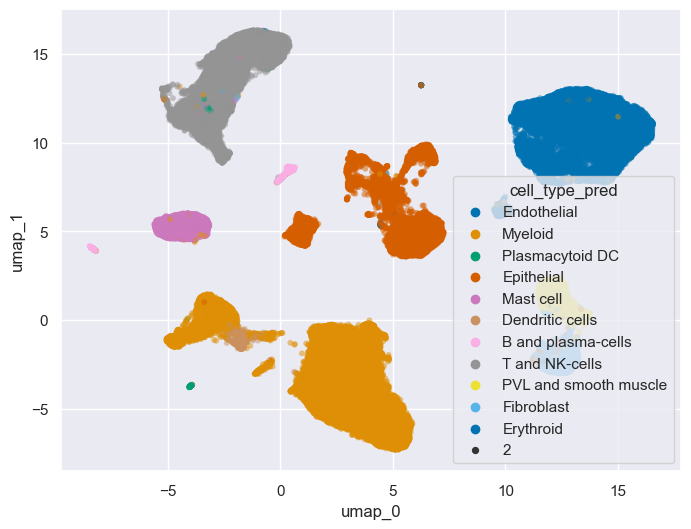

In [77]:
# Plot UMAP projections of embedding results alongside predicted cell-type label

embeddings = pd.read_csv(os.path.join(res_dir,'84772c860ce6445d8b27e8ed81a474bc','results.csv'))
embeddings = embeddings.set_index('barcode')

sns.set_theme(rc={'figure.figsize':(8,6)})
sns.scatterplot(x=embeddings['umap_0'],
                y=embeddings['umap_1'],
                hue=embeddings['cell_type_pred'],
                linewidth=0,palette='colorblind',
                size=2,alpha=0.5)

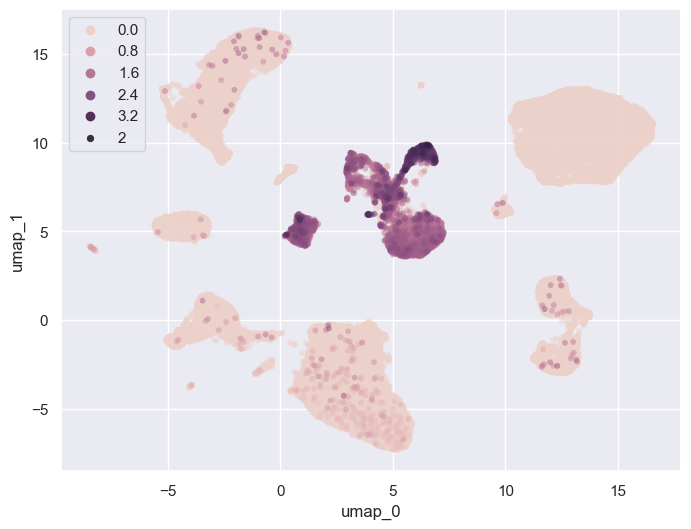

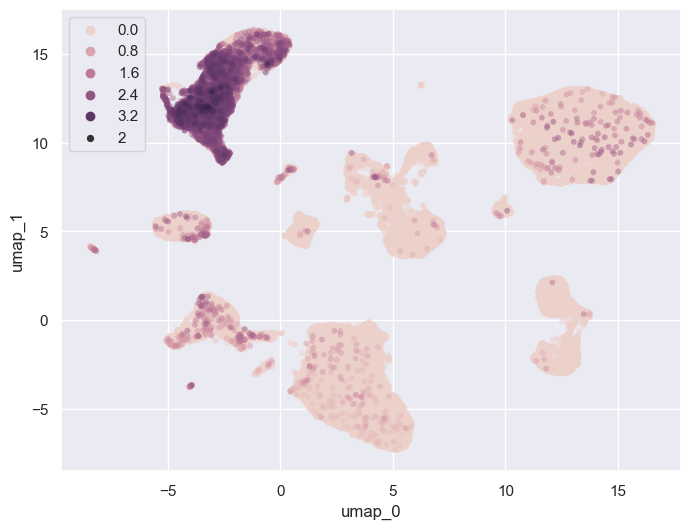

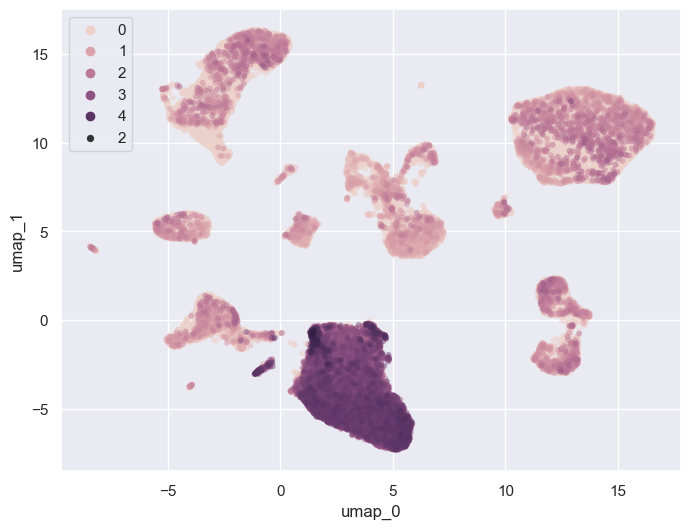

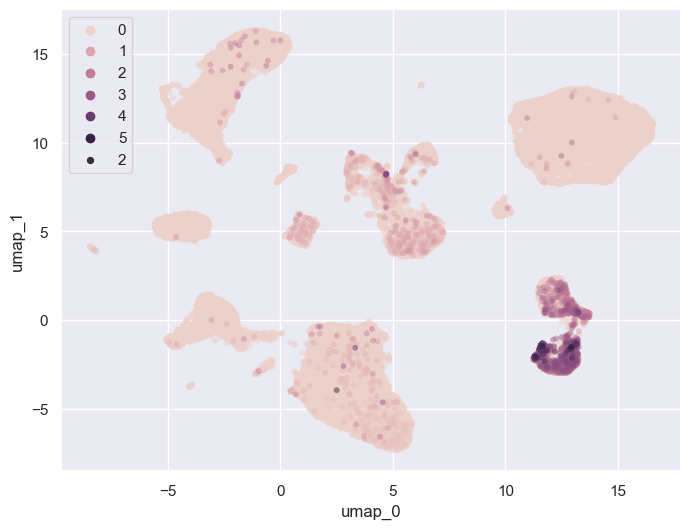

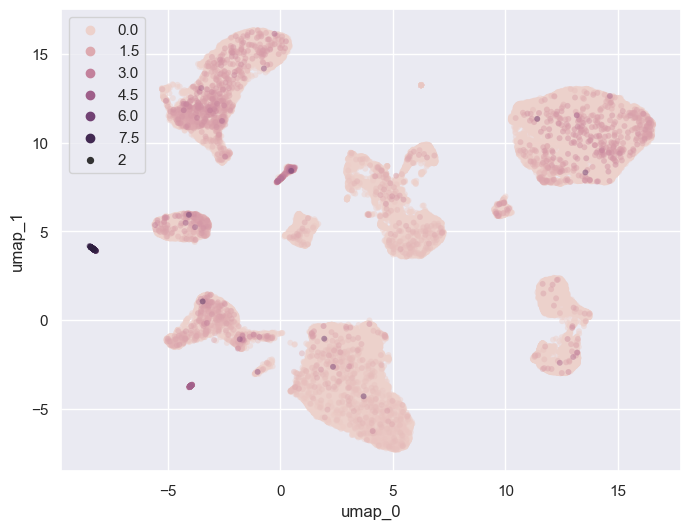

In [81]:
# Overlay some commonly expressed genes on the UMAP projection

ad = sc.read_h5ad(h5ad_path)
new_obs = ad.obs.join(embeddings)

for gene in ['EPCAM','CD3E','MARCO','COL1A1','JCHAIN']:
    
    exp_vec = np.asarray(ad[:,ad.var['feature_name'] ==gene].X.todense()).flatten()
    inds = np.argsort(exp_vec)
    sns.scatterplot(x=new_obs['umap_0'][inds],
                    y=new_obs['umap_1'][inds],
                    hue=exp_vec[inds],linewidth=0,
                    size=2,alpha=0.5)
    plt.show()